# 1. Lets use YAHOO FINANCE API for data gathering

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf  # Yahoo Finance API
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

In [16]:
# Set the ticker symbol, start date, and end date
ticker = "AAPL"  # Apple Inc.
start_date = "2018-01-01"
end_date = "2022-12-31"

# Download the stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Display information about the data
print("Data shape:", data.shape)
print("\nDate range:")
print(f"Start: {data.index.min()}")
print(f"End: {data.index.max()}")
print("\nFirst few rows:")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Data shape: (1259, 5)

Date range:
Start: 2018-01-02 00:00:00
End: 2022-12-30 00:00:00

First few rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.479836  40.489237  39.774858  39.986353  102223600
2018-01-03  40.472786  41.017971  40.409341  40.543284  118071600
2018-01-04  40.660786  40.764183  40.437543  40.545638   89738400
2018-01-05  41.123722  41.210668  40.665487  40.757134   94640000
2018-01-08  40.970978  41.267067  40.872278  40.970978   82271200


In [17]:
# Check for any missing values
print("\nMissing values in each columns:")
print(data.isnull().sum())
#Basic Stats
print("\Basic Statistics:")
print(data.describe())


Missing values in each columns:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64
\Basic Statistics:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean      95.702890    96.801484    94.519861    95.640169  1.168806e+08
std       46.139144    46.720911    45.520934    46.131170  5.504461e+07
min       33.915253    34.757230    33.869933    34.342203  3.519590e+07
25%       48.939255    49.328004    48.508400    48.946827  8.014245e+07
50%       89.189926    90.491788    88.486683    88.846815  1.023002e+08
75%      140.533104   141.942078   138.793231   140.569245  1.372052e+08
max      178.879913   179.793920   176.039607   179.489254  4.265100e+08


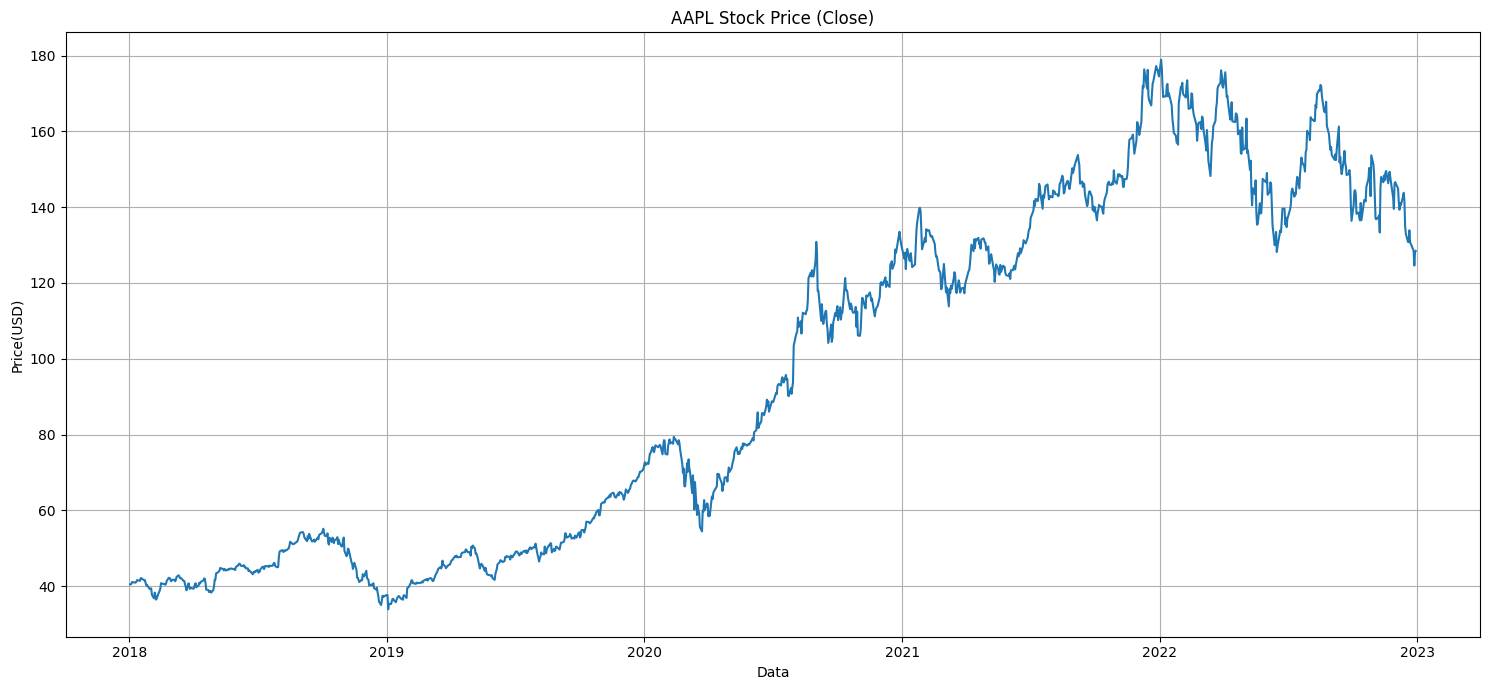

In [18]:
#Plor the closing price over time
plt.figure(figsize=(15,7))
plt.plot(data.index, data['Close'])
plt.title(f'{ticker} Stock Price (Close)')
plt.xlabel('Data')
plt.ylabel('Price(USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Feature Engineering for Time-Series

In [19]:
# Create a copy of the original data
stock_data = data.copy()

#Extract Date features
stock_data['Year'] = stock_data.index.year
stock_data['Month'] = stock_data.index.month
stock_data['Day'] = stock_data.index.day
stock_data['DayOfWeek'] = stock_data.index.dayofweek

#Calculate price-based features
stock_data['PriceRange'] = stock_data['High']-stock_data['Low']
stock_data['DailyReturn'] = stock_data['Close'].pct_change()

# Create Lagged features (previous days' prices)
for lag in range(1, 6):
    stock_data[f'Close_Lag_{lag}'] = stock_data['Close'].shift(lag)
    stock_data[f'Volume_Lag_{lag}'] = stock_data['Volume'].shift(lag)

# Calculate moving average
for window in [5, 10, 20, 50]: #common moving average windows
    stock_data[f'MA_{window}'] = stock_data['Close'].rolling(window=window).mean()

# Calculate technical indicators
# Relative Strength Indec (RSI) -  simplfied version
delta = stock_data['Close'].diff()
gain = delta.where(delta>0,0)
loss = -delta.where(delta<0,0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain/avg_loss
stock_data['RSI'] = 100-(100/(1+rs))

# Moving Average Convergence Divergence (MACD)
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9).mean()

# DROP rows with NAN values
stock_data = stock_data.dropna()

print("Features create. New Shape:", stock_data.shape)
print("\nColumns:", stock_data.columns.tolist())

Features create. New Shape: (1210, 30)

Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('Year', ''), ('Month', ''), ('Day', ''), ('DayOfWeek', ''), ('PriceRange', ''), ('DailyReturn', ''), ('Close_Lag_1', ''), ('Volume_Lag_1', ''), ('Close_Lag_2', ''), ('Volume_Lag_2', ''), ('Close_Lag_3', ''), ('Volume_Lag_3', ''), ('Close_Lag_4', ''), ('Volume_Lag_4', ''), ('Close_Lag_5', ''), ('Volume_Lag_5', ''), ('MA_5', ''), ('MA_10', ''), ('MA_20', ''), ('MA_50', ''), ('RSI', ''), ('EMA_12', ''), ('EMA_26', ''), ('MACD', ''), ('MACD_Signal', '')]


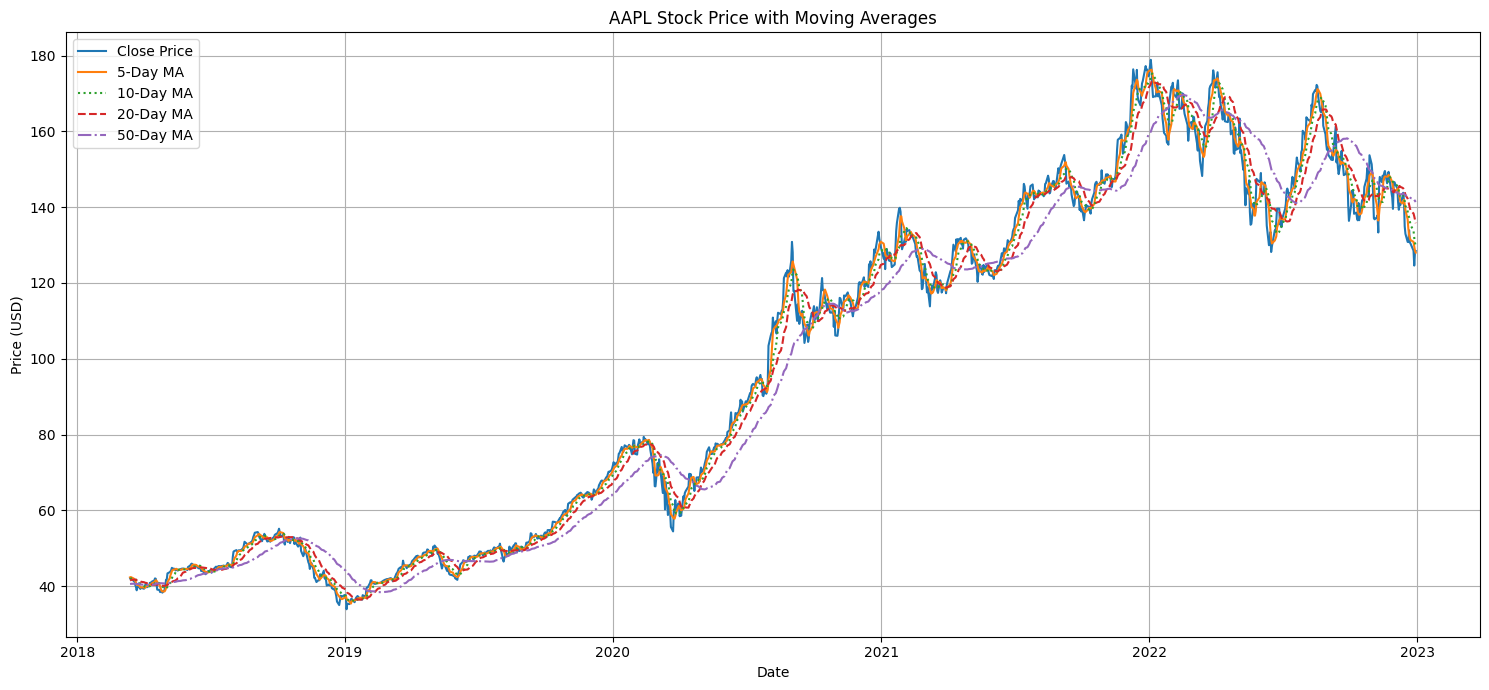

In [20]:
# Visualize Key Features
# Plot closing price with moving averages
plt.figure(figsize=(15, 7))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
plt.plot(stock_data.index, stock_data['MA_5'], label='5-Day MA', linestyle='-')
plt.plot(stock_data.index, stock_data['MA_10'], label='10-Day MA', linestyle=':')
plt.plot(stock_data.index, stock_data['MA_20'], label='20-Day MA', linestyle='--')
plt.plot(stock_data.index, stock_data['MA_50'], label='50-Day MA', linestyle='-.')
plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

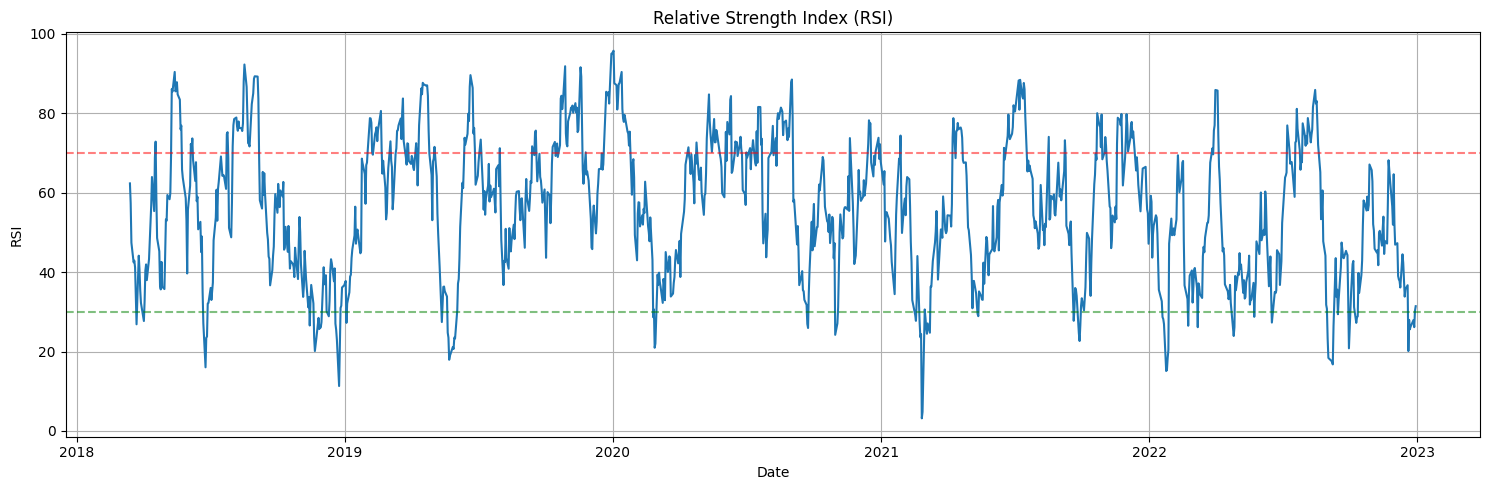

In [21]:
# Plot RSI
plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data['RSI'])
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)  # Overbought line
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)  # Oversold line
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.tight_layout()
plt.show()

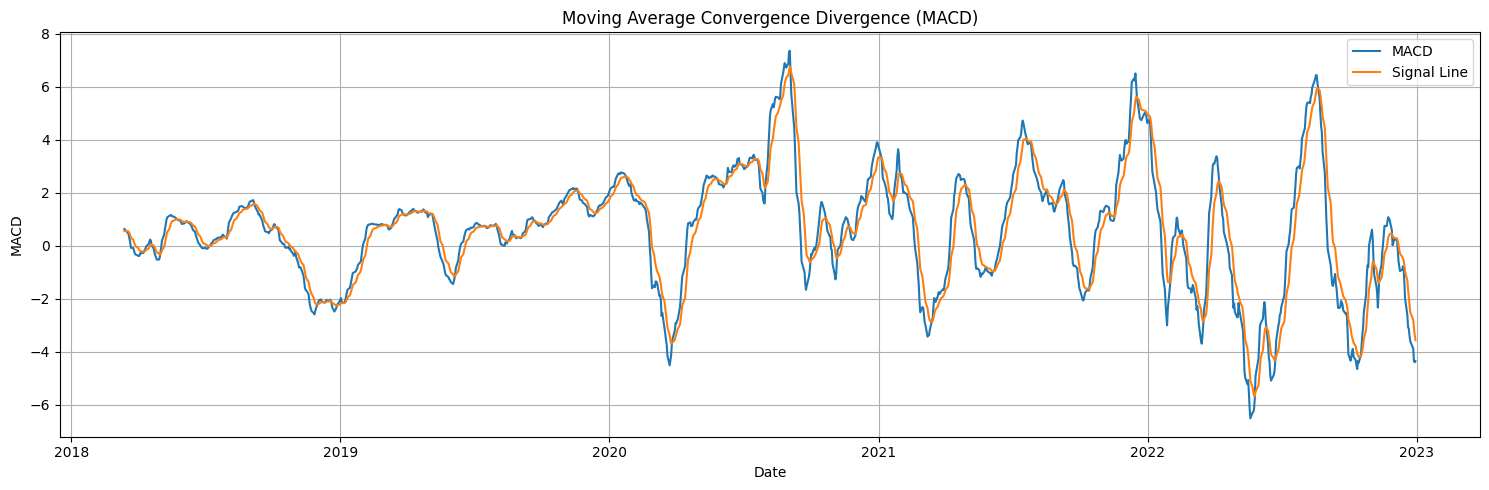

In [22]:
# Plot MACD
plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data['MACD'], label='MACD')
plt.plot(stock_data.index, stock_data['MACD_Signal'], label='Signal Line')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Define prediction target: next day's closing price
stock_data['Target'] = stock_data['Close'].shift(-1) # tomorrow's closing price
# Drop specifically the last row which has no target
stock_data = stock_data.iloc[:-1]
# Then drop any remaining rows with NaN values from our feature engineering
stock_data = stock_data.dropna()
display(stock_data)
# Convert tuple-based column names to single strings to simplify things
stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]

# Now check the columns again
print("Simplified columns:", stock_data.columns.tolist())

# Define features
features = stock_data.columns.tolist()
if 'Target' in features:
    features.remove('Target')
    print("Removed 'Target' from features list")

# Remove original price columns
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in price_cols:
    if col in features:
        features.remove(col)
        print(f"Removed '{col}' from features list")

print("\nEngineered features for modeling:", features)

X = stock_data[features]
y = stock_data['Target']

#Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
print("Features for modeling:", features)
print("\nFeature data shape:", X.shape)
print("Target data shape:", y.shape)

Price,Close,High,Low,Open,Volume,Year,Month,Day,DayOfWeek,PriceRange,...,MA_5,MA_10,MA_20,MA_50,RSI,EMA_12,EMA_26,MACD,MACD_Signal,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-14,42.103058,42.593836,41.954408,42.546646,117473600,2018,3,14,2,0.639428,...,42.331927,41.923260,41.479791,40.570716,62.364661,41.855118,41.225216,0.629902,0.552825,42.152615
2018-03-15,42.152615,42.527779,42.015766,42.117223,90975200,2018,3,15,3,0.512013,...,42.412623,42.009383,41.612868,40.604172,57.418770,41.900896,41.295296,0.605600,0.563380,42.003948
2018-03-16,42.003948,42.263492,41.909566,42.152595,157618800,2018,3,16,4,0.353926,...,42.320130,42.052089,41.672209,40.634795,47.417037,41.916753,41.348766,0.567986,0.564301,41.362171
2018-03-19,41.362171,41.874184,40.975212,41.838793,133787200,2018,3,19,0,0.898972,...,42.017169,42.016224,41.706068,40.648823,42.474568,41.831420,41.349776,0.481644,0.547770,41.348022
2018-03-20,41.348022,41.716105,41.277236,41.348022,78597600,2018,3,20,1,0.438869,...,41.793963,41.982485,41.746062,40.653309,42.913519,41.757042,41.349644,0.407398,0.519695,40.411297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,130.710236,133.013458,128.802425,132.805880,77852100,2022,12,22,3,4.211033,...,131.839102,136.284421,139.847498,142.618618,25.595180,136.076417,139.484404,-3.407987,-2.245330,130.344498
2022-12-23,130.344498,130.898059,128.150012,129.415299,63814900,2022,12,23,4,2.748047,...,131.315198,135.266260,139.044337,142.403257,26.261606,135.194584,138.807374,-3.612791,-2.518822,128.535507


Simplified columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'PriceRange', 'DailyReturn', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_4', 'Volume_Lag_4', 'Close_Lag_5', 'Volume_Lag_5', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'Target']
Removed 'Target' from features list
Removed 'Open' from features list
Removed 'High' from features list
Removed 'Low' from features list
Removed 'Close' from features list
Removed 'Volume' from features list

Engineered features for modeling: ['Year', 'Month', 'Day', 'DayOfWeek', 'PriceRange', 'DailyReturn', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_4', 'Volume_Lag_4', 'Close_Lag_5', 'Volume_Lag_5', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal']
Features for modeling: ['Year', 'Month', 'Day', 'DayOfWeek', 'PriceRang

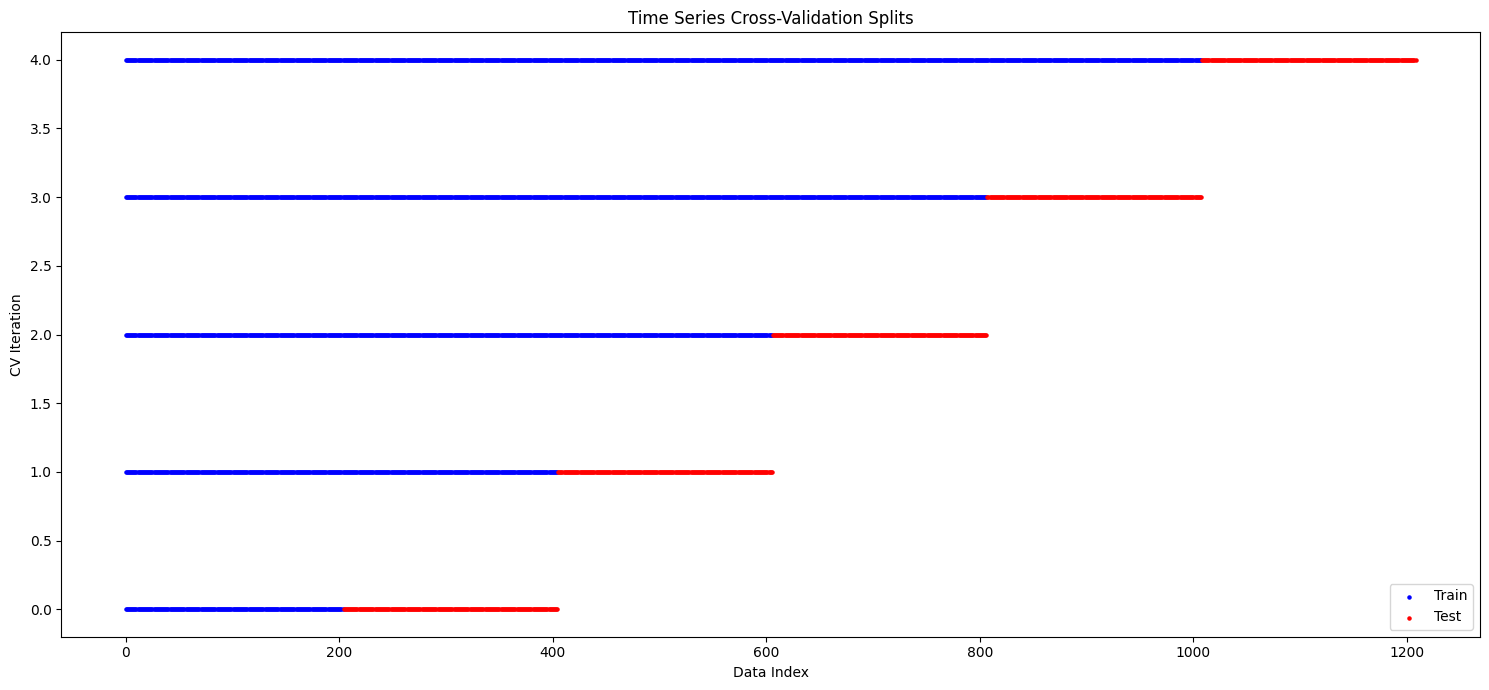

In [24]:
# Import the TimeSeriesSplit tool
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the splits to understand how they work
plt.figure(figsize=(15, 7))
for i, (train_index, test_index) in enumerate(tscv.split(X_scaled)):
    plt.scatter(train_index, [i] * len(train_index), c='blue', s=5, label='Train' if i == 0 else "")
    plt.scatter(test_index, [i] * len(test_index), c='red', s=5, label='Test' if i == 0 else "")

plt.title('Time Series Cross-Validation Splits')
plt.xlabel('Data Index')
plt.ylabel('CV Iteration')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Use the last split for final training/testing
for i, (train_index, test_index) in enumerate(tscv.split(X_scaled)):
    if i == 4:  # The last split
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"Training set: {X_train.shape[0]} rows (from {X_train.index.min()} to {X_train.index.max()})")
print(f"Testing set: {X_test.shape[0]} rows (from {X_test.index.min()} to {X_test.index.max()})")

Training set: 1008 rows (from 2018-03-14 00:00:00 to 2022-03-14 00:00:00)
Testing set: 201 rows (from 2022-03-15 00:00:00 to 2022-12-29 00:00:00)


In [26]:
# Import XGBoost
import xgboost as xgb

# Create the XGBoost model with carefully chosen parameters
model = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.05,  # Learning rate
    max_depth=5,  # Maximum tree depth
    min_child_weight=1,  # Minimum sum of weights in a child
    subsample=0.8,  # Fraction of samples used for training trees
    colsample_bytree=0.8,  # Fraction of features used for training trees
    random_state=42  # For reproducibility
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on both training and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [27]:
# Calculate performance metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# Calculate performance metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

# Calculate Mean Absolute Percentage Error (MAPE) for test set
test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

# Print the results
print("Training Set Performance:")
print(f"RMSE: ${train_rmse:.2f}")
print(f"MAE: ${train_mae:.2f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Performance:")
print(f"RMSE: ${test_rmse:.2f}")
print(f"MAE: ${test_mae:.2f}")
print(f"R²: {test_r2:.4f}")
print(f"MAPE: {test_mape:.2f}%")

Training Set Performance:
RMSE: $1.03
MAE: $0.75
R²: 0.9994

Test Set Performance:
RMSE: $4.02
MAE: $3.23
R²: 0.8866
MAPE: 2.17%


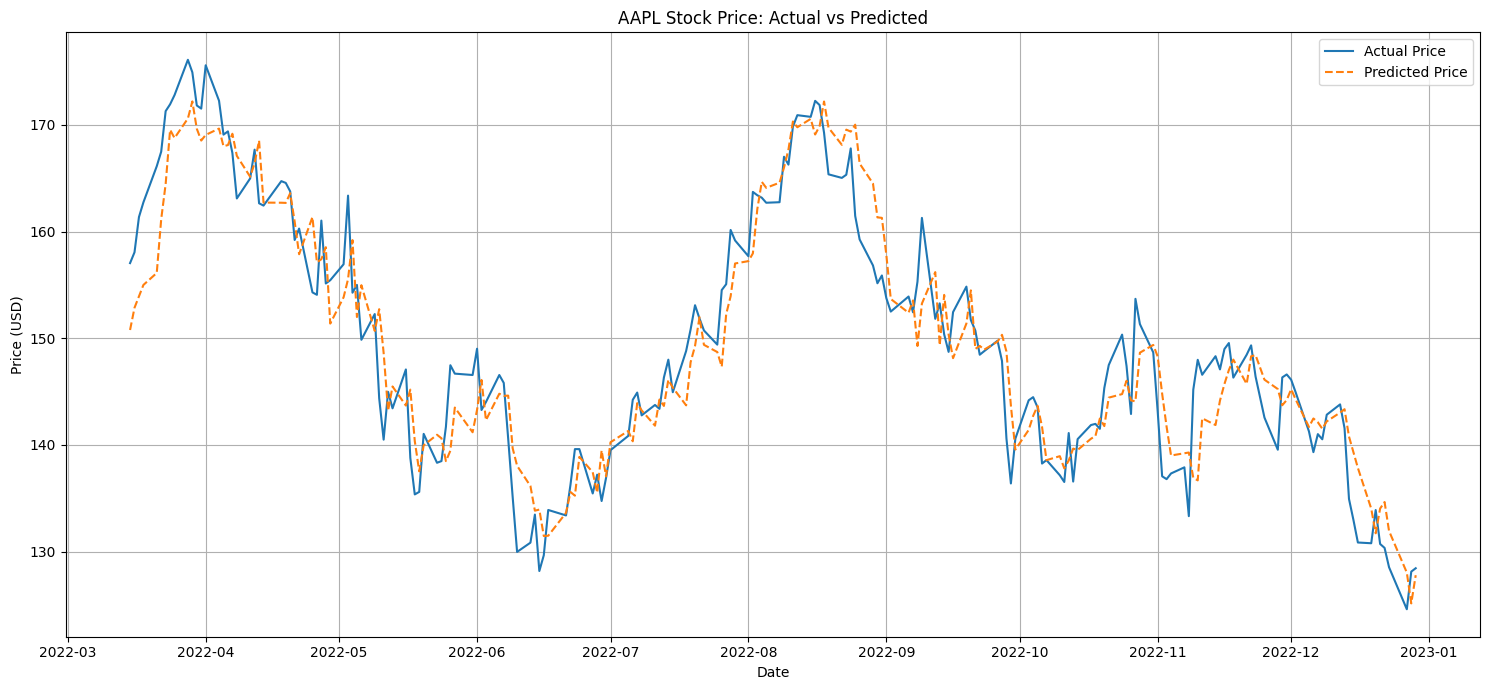

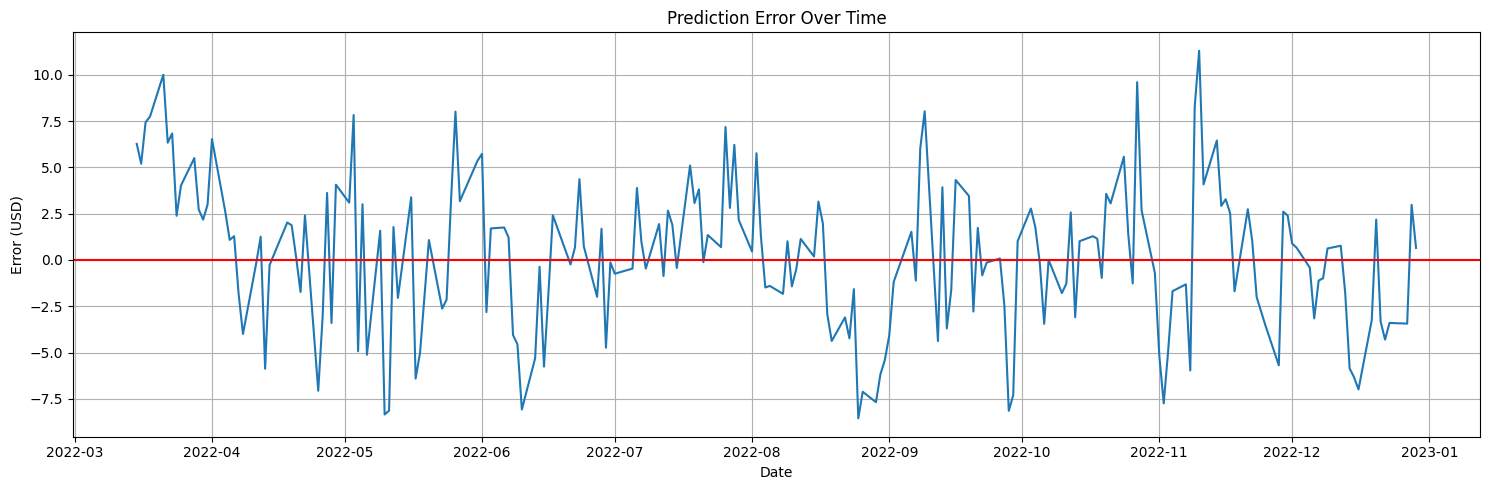

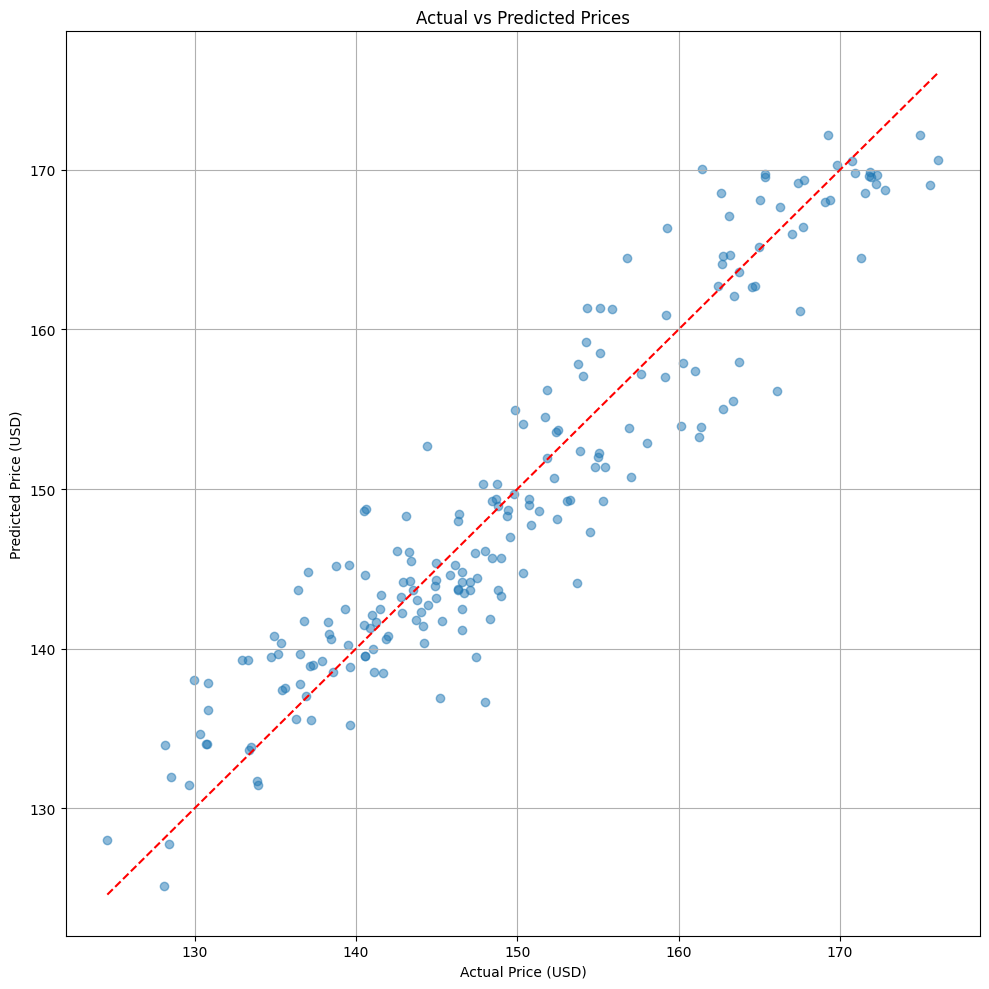

In [28]:
# Create a DataFrame for actual vs predicted values
results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': test_pred
})

# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(results['Date'], results['Actual'], label='Actual Price')
plt.plot(results['Date'], results['Predicted'], label='Predicted Price', linestyle='--')
plt.title(f'{ticker} Stock Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the error over time
results['Error'] = results['Actual'] - results['Predicted']
plt.figure(figsize=(15, 5))
plt.plot(results['Date'], results['Error'])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot a scatter plot of actual vs predicted
plt.figure(figsize=(10, 10))
plt.scatter(results['Actual'], results['Predicted'], alpha=0.5)
plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

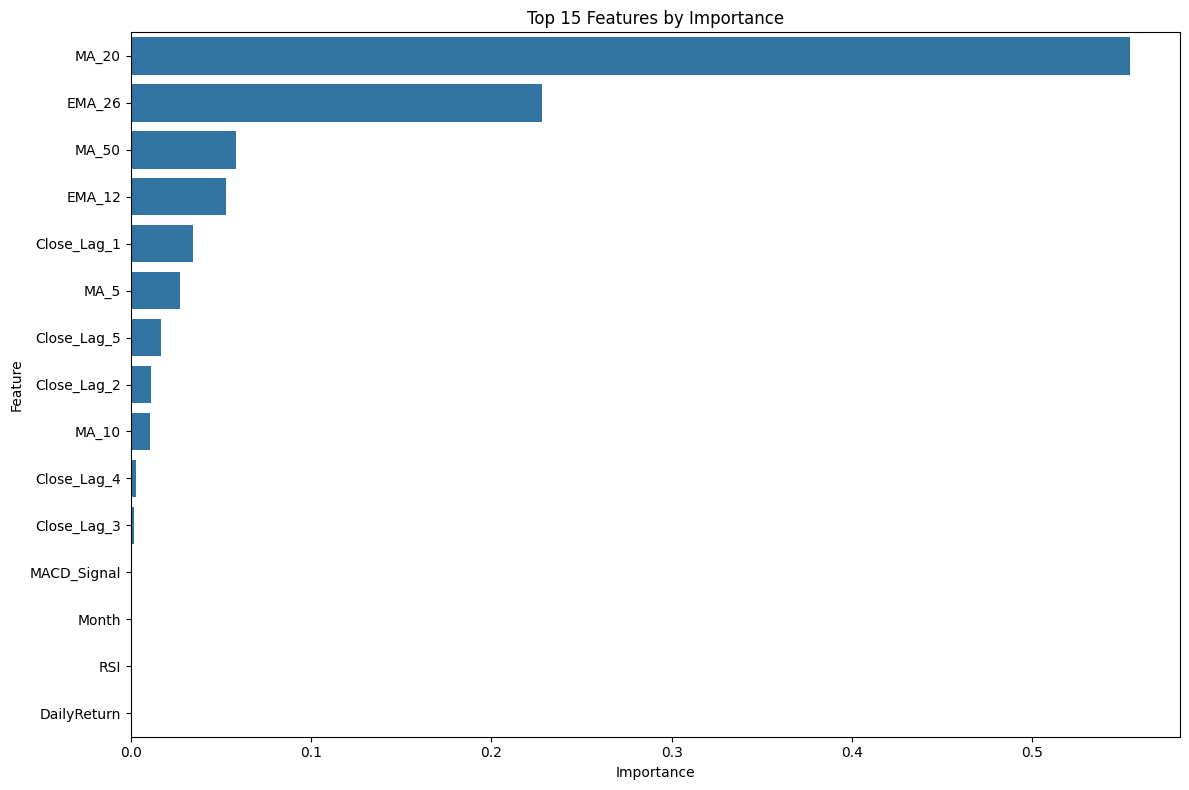

Top 5 most important features:
        Feature  Importance
18        MA_20    0.554288
22       EMA_26    0.227874
19        MA_50    0.058356
21       EMA_12    0.052637
6   Close_Lag_1    0.034752


In [29]:
# Get feature importance from the model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

print("Top 5 most important features:")
print(feature_importance.head(5))